# Week 4: Convolutional Neural Networks

We learned about feedforward neural networks over the last two weeks, along with most of the fundamental maths, algorithms, tricks, etc. that go into training them. Knowing how inputs propagate forward in the network, how gradients flow backwards and how weights get updated, we are now ready to release our imagination and create some deep neural networks that can do remarkable things. We will first focus on one of the most **powerful architectures**, the Convolutional Neural Network (CNN), which has completely revolutionalized image recognition in science and tech.

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from keras import layers

## Exercises

The problem with feed forward images when classifying images is that the input layer looks at the whole image at once. Each input neuron thus becomes associated with a *specific* pixel, and as the network learns it may grow to expect a certain signal to emerge at that particular pixel. But if you imagine an image of a cat, features, like the whiskers, which make it cat-like, are not bound to a specific *place* in the image – they can be in the centre, top corner, or any other place.

CNNs solve this problem, with what's called *convolutional layers*. A convolutional input layer, for example, doesn't have a single weight for each input value. Instead, it has one or more much smaller *filters*, each one a set of input neurons (often $3 \times 3 \times d$ where $d$ is the depth of the input image (3 if it's an RGB image, 1 if its black and white)) that gets *convolved* across the input image to produce a new image, called an *activation map*. [Here](https://github.com/vdumoulin/conv_arithmetic) are some nice gifs that illustrate different ways one can convolve a weight matrix across an input image.

#### Pen and paper

To get your intuition for computations on input data in CNNs fine-tuned, a few small quizzes for you. First, we'll consider the size of the parameter space.

> **Ex. 4.1.1**: Imagine you have a CNN with just one convolutional layer with a single filter. All it does, is take an input image and produce an activation map. The dimensionality of the filter in your convolutional layer is $5 \times 5 \times 3$. How many weights (or *parameters*) are there in this model?
>
> *Hint*: Don't forget the bias!

A: There are 75 weights and 1 bias for 76 total parameters in the model.

Here's the formula for computing the size of the activation map resulting from a convolution.
If you have a filter that is $F$ wide, your input image is $W_0$ wide, you are padding the edges by
$P$ pixels and your stride is $S$, the resulting image will have width/height:

$$ W_1 = \frac{W_0 - F + 2P}{S} + 1 $$

> **Ex. 4.1.2**: You input an image of dimensions $28 \times 28 \times 3$, use a padding of 2, a stride of 1,
and then slide your $5 \times 5 \times 3$ filter across the image. What is the dimensionality of the resulting activation map?

The dimensionality of the resulting activation map would be 28x28x1.

> **Ex. 4.1.3**: Let's say you now want to use a stride of 2, instead of 1. What problem does this immediately cause?
How can we solve it?

It causes a size matching problem, we can't apply the filter over the whole image because it does not fit at the end. Taking strides of length 2 will end up with a last window that goes over the edge of the padded image. To solve this we can change the filter size to be 6x6x3 or we can remap the input image to 29x29x3, adding an uneven layer of padding, one layer to the side and bottom of the image.

*Maxpooling* is a method used a lot in CNNs, which downsamples the size of an activation map. It is used primarily to reduce the amount of parameters and computations needed in the network, and to avoid overfitting. Here's an illustration of how it works:

![img](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

Typically, for each $2 \times 2$ square in your activation map, you pick the largest value in that square. You do this independently for every depth slice in your activation map.

**Note:** In Keras, the dimension of data is a little different from what you may expect. The first index,
indexes datapoints, the second and third are the dimensions of your images, and the last is number of channels. So if
you have a batch of data containing 100 datapoints, each one an RGB image (so 3 channels: red, green, blue)
with resolution $128 \times 128$, then the dimensionality of your input data is (100, 128, 128, 3).

> **Ex. 4.1.4**: Activation maps are the output of a convolution operation with a kernel. Given the (random generated) activation map below, what is the corresponding activation map after maxpooling ($2 \times 2$ filter, stride 2)? Run it through a Keras maxpooling layer ([check out the docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)), and report the dimensionality.

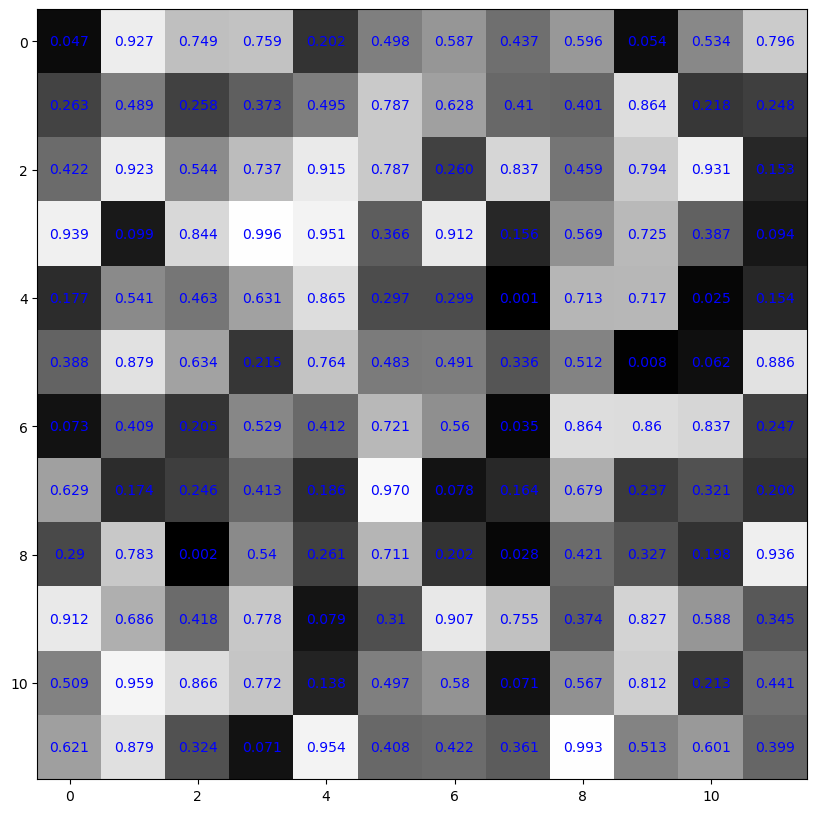

In [ ]:
# Random generating an activation map 'a' with dimension
# [number of datapoints (images) = 1,
#  number of rows = 12,
#  number of cols = 12,
#  number of channels = 1]
a = np.random.random(size=(1, 12, 12, 1))
activation_map = keras.backend.variable(a)

# Let us plot the output
fig, ax = plt.subplots(figsize=[10,10])
im = ax.imshow(activation_map[0,:,:,0], cmap='gray', vmin=0, vmax=1)

for i in range(12):
    for j in range(12):
        text = ax.text(j, i, np.format_float_positional(activation_map[0,i,j,0], precision=3),
                       ha="center", va="center", color="blue")



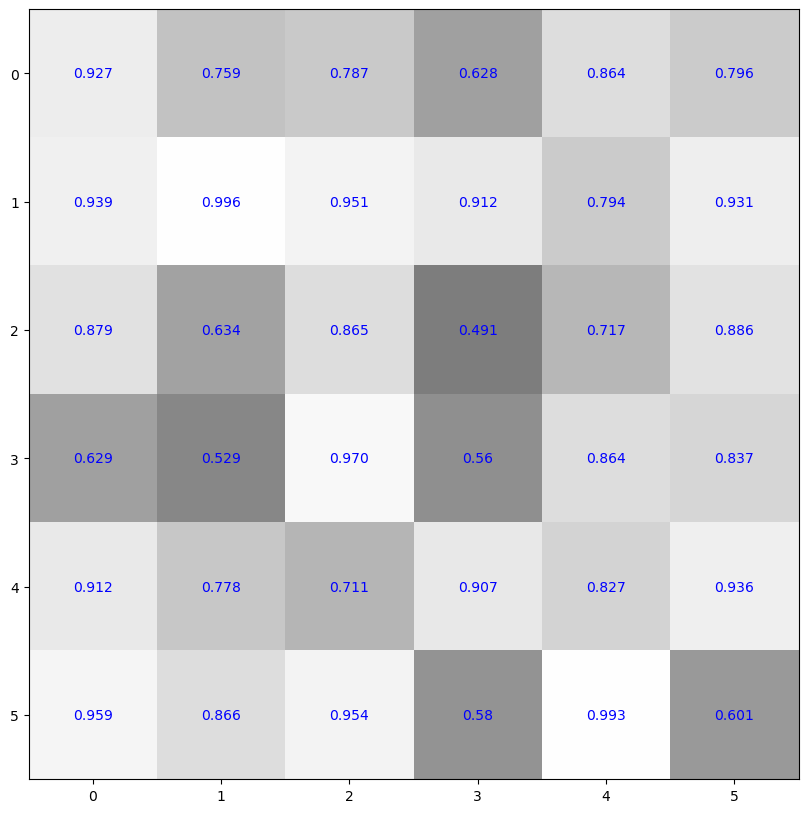

In [ ]:
max_pool_2d = keras.layers.MaxPooling2D(pool_size=(2, 2),
   strides=2)


pooled_output = max_pool_2d(activation_map)
#print(pooled_output)
fig, ax = plt.subplots(figsize=[10,10])
im = ax.imshow(pooled_output[0,:,:,0], cmap='gray', vmin=0, vmax=1)

for i in range(6):
    for j in range(6):
        text = ax.text(j, i, np.format_float_positional(pooled_output[0,i,j,0], precision=3),
                       ha="center", va="center", color="blue")

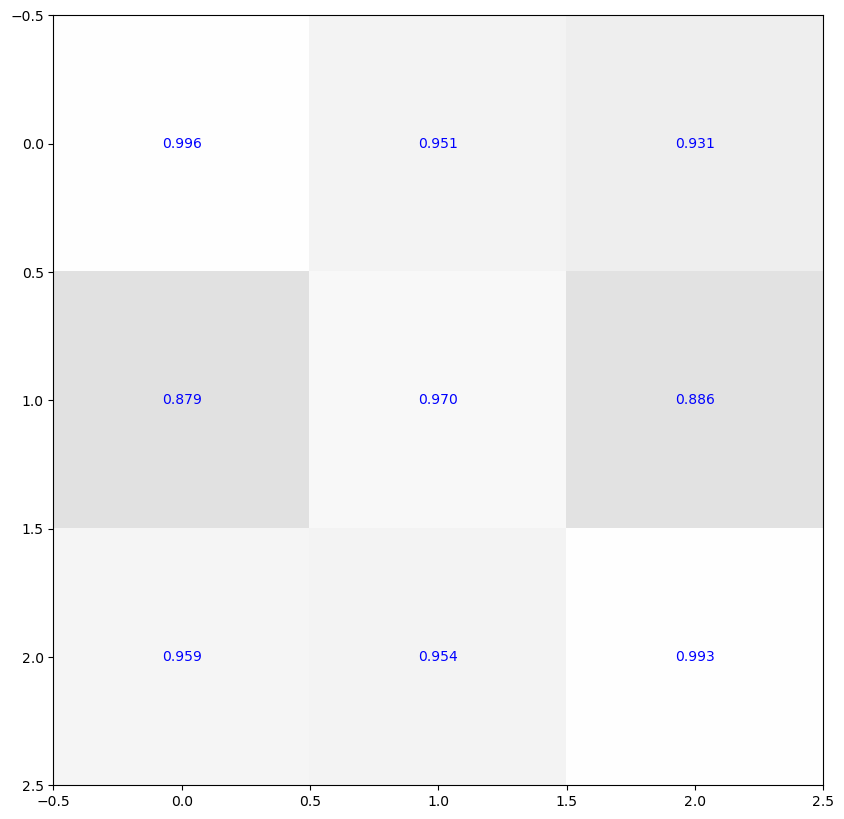

In [ ]:
max_pool_2d = keras.layers.MaxPooling2D(pool_size=(2, 2),
   strides=2)


pooled_output2 = max_pool_2d(pooled_output)
#print(pooled_output)
fig, ax = plt.subplots(figsize=[10,10])
im = ax.imshow(pooled_output2[0,:,:,0], cmap='gray', vmin=0, vmax=1)

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, np.format_float_positional(pooled_output2[0,i,j,0], precision=3),
                       ha="center", va="center", color="blue")

With a maxpooling filter with a 2x2 filter and stride length of 2, we get an activation map of 6x6x1, effectively cutting the dimensions in half for each dimension (row,col) and taking the largest value from each cell of four to keep in the maxpooling layer. We can see this again when we run the same filter on the now 6x6 layer we end up with a 3x3 layer where the same max value selecting occurs.

#### CNNs in Keras

For example sake, I've implemented a single conv. layer neural network Keras below.

In [ ]:
model = Sequential([
    Conv2D(filters=10, kernel_size=(3,3), strides=(1, 1), input_shape=[28,28,1], padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(10)
])

In the following exercise you will use the MNIST dataset again. In the cell below we've written some code to prepare it somewhat. Really try to understand what's happening here.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape data to have a color-channel dimension (even though it's grayscale)
rows, cols = x_train.shape[-2:]
x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)

# Convert pixel intensities to values between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert target vectors to one-hot encoding
num_classes = len(set(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

> **Ex. 4.1.5**: Implement Nielsen's [last convolutional neural network](http://neuralnetworksanddeeplearning.com/chap6.html#problem_437600)
(the one with *two convolutional layers + dropout*), and score an accuracy higher than 98% on the test data. It doesn't have to be
fully identical, but his solution is good, so getting close is an easy way to score a high accuracy.
>
> *Hint:* [here](https://keras.io/examples/vision/mnist_convnet/) is an example of a CNN in Keras. Not to copy line by line, but just to have a reference for how it's done, remember you want something similar to Nielsen's.

The MNIST dataset is a great benchmark because it allows us to directly measure the performance of a neural
network against the human eye. But often, the association between datapoint and label is not as clear, yet we
still want to do prediction.

In [ ]:
# >>> net = Network([
#         ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28),
#                       filter_shape=(20, 1, 5, 5),
#                       poolsize=(2, 2),
#                       activation_fn=ReLU),
#         ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12),
#                       filter_shape=(40, 20, 5, 5),
#                       poolsize=(2, 2),
#                       activation_fn=ReLU),
#         FullyConnectedLayer(
#             n_in=40*4*4, n_out=1000, activation_fn=ReLU, p_dropout=0.5),
#         FullyConnectedLayer(
#             n_in=1000, n_out=1000, activation_fn=ReLU, p_dropout=0.5),
#         SoftmaxLayer(n_in=1000, n_out=10, p_dropout=0.5)],
#         mini_batch_size)
# >>> net.SGD(expanded_training_data, 40, mini_batch_size, 0.03,
#             validation_data, test_data)

In [ ]:
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1)

# Sequential model definition
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),

        # 1st Conv2D layer with max pooling
        layers.Conv2D(20, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # 2nd Conv2D layer with max pooling
        layers.Conv2D(40, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),

        # 1st Fully Connected layer with ReLU and dropout
        layers.Dense(1000, activation="relu"),
        layers.Dropout(0.5),

        # 2nd Fully Connected layer with ReLU and dropout
        layers.Dense(1000, activation="relu"),
        layers.Dropout(0.5),

        # output layer with 10 units for classification with softmax
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=40, batch_size=10,
    callbacks=[early_stopping]
)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 20)     │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 12, 12, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 40)       │        20,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 4, 4, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1000)           │       641,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,672,570 (6.38 MB)

 Trainable params: 1,672,570 (6.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.7590 - loss: 0.7170 - val_accuracy: 0.9771 - val_loss: 0.0748
Epoch 2/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9670 - loss: 0.1058 - val_accuracy: 0.9869 - val_loss: 0.0423
Epoch 3/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9769 - loss: 0.0758 - val_accuracy: 0.9881 - val_loss: 0.0350
Epoch 4/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9816 - loss: 0.0596 - val_accuracy: 0.9900 - val_loss: 0.0318
Epoch 5/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9859 - loss: 0.0476 - val_accuracy: 0.9909 - val_loss: 0.0268
Epoch 6/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9868 - loss: 0.0414 - val_accuracy: 0.9902 - val_loss: 0.0286
Epoch 7/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9879 - loss: 0.0363 - val_accuracy: 0.9928 - val_loss: 0.0233
Epoch 8/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9904 - loss: 0

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0) # verbose 0 so no print out

# Print the results
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)


Test Loss:  0.023709774017333984
Test Accuracy:  0.9922000169754028


We were able to get our Test Accuracy to 99.22% which is higher than 98% which we needed to achive.

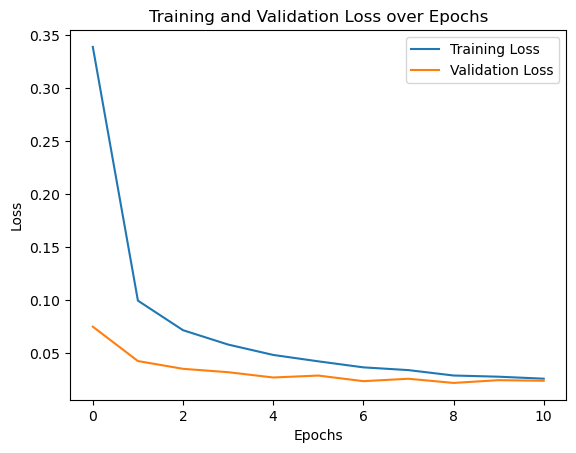

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
